# 【8】2008.1-2021.9年的来澳旅客空路人次（90%数据建模）

## 0.1-导入包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.tsa.api as smt
import statsmodels.tsa.arima.model as smt2
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test

## 0.2-绘制时序图、ACF、PACF图（statsmodels自带的函数）

In [2]:
def drawts(y,pname,Type,notes,mylag=36):
    ##draw ax
    fig = plt.figure(figsize=(15,12))
    ts_ax=plt.subplot2grid((2,2),(0,0),colspan=2)
    acf_ax=plt.subplot2grid((2,2),(1,0))
    pacf_ax=plt.subplot2grid((2,2),(1,1))
    ##draw plot
    ts_ax.plot(y,'*-')
    smt.graphics.plot_acf(y,lags=mylag,ax=acf_ax,alpha=0.05) ##2sigma
    smt.graphics.plot_pacf(y,lags=mylag,ax=pacf_ax,alpha=0.05)  ##2sigma
    
    
    # plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['font.size'] = '15'
    plt.rcParams['axes.unicode_minus'] = False
    
    fig.suptitle("Time Series Analysis Plots of %s by %s(90%% data)"%(notes,Type),fontsize = 20)
    ts_ax.set_title('Sequence Chart')
    ts_ax.set_xlabel("Time(months)")
    ts_ax.set_ylabel("Number of %s passengers(person)"%Type)
    acf_ax.set_xlabel("number of lags(period)")
    acf_ax.set_ylabel("correlation")
    pacf_ax.set_xlabel("number of lags(period)")
    pacf_ax.set_ylabel("correlation")
    plt.savefig("Time Series Analysis Plots of %s(90%% data) by %s.jpg"%(notes,Type),dpi=256)
    plt.show()
    plt.close()

## 0.3-LB统计量（statsmodels自带的LB test函数）

In [3]:
def purerandtest(y,mylag=24):
    a,b=lb_test(y,lags=mylag,boxpierce=False)
    LB_purerand=pd.DataFrame(np.c_[a,b],columns=['LB','Pvalue'])
    LB_purerand['lags']=range(1,len(a)+1)
    print('----time series: LB pure randomness test----')
    print(LB_purerand)

## 0.4-绘图（真实值+拟合值+预测值）

In [17]:
def plot_all(y,mypred,Type,mylen):
    plt.figure(figsize=(24,12))         # 设置画布大小
    plt.plot(y,'-',label='observe')                                # 真实值
    startdraw=20
    plt.plot(np.arange(startdraw,mypred.predicted_mean.shape[0]),mypred.predicted_mean[startdraw:],'-*',label='fit')
    plt.plot(np.arange(mylen,mypred.predicted_mean.shape[0]),mypred.predicted_mean[mylen:],'-*',label='predict')

    plt.fill_between(np.arange(startdraw,mypred.predicted_mean.shape[0]),
                 mypred.conf_int(0.05)[startdraw:,0],
                 mypred.conf_int(0.05)[startdraw:,1],
                 color='lightblue')                    # 绘制置信区间
    plt.rcParams['font.size'] = '15'
    plt.legend()                                          # 添加图例
    plt.xlabel("Time(months)")                            # xlabel 
    plt.ylabel("Number of %s passengers(person)"%Type)    # ylabel
    plt.title('%s(90%% data)\'s fitted and predictive value'%Type)   # 添加标题
    plt.savefig('%s(90%% data)\'s fitted and predictive value.jpg'%Type,dpi=256)
    plt.show()                                    # 显示图像
    plt.close()                                   # 关闭图像

## 0.5-模型比较定阶

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from statsmodels.tsa.arima_model import ARIMA
import warnings
# 忽视在模型拟合中遇到的错误
warnings.filterwarnings("ignore")
# 找最优的参数 SARIMAX
def find_best_params(data:np.array, params_list,m):
    result = []
    best_bic = 100000
    for param in tqdm_notebook(params_list):
        # 模型拟合
        # model = SARIMAX(data,order=(param[0], param[1], param[2]),seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
        model = SARIMAX(data, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
        bicc = model.bic # 拟合出模型的BIC值
        # print(bic)
        # 寻找最优的参数
        if bicc < best_bic:
            best_mode = model
            best_bic = bicc
            best_param = param
        param_1 = (param[0], param[1], param[2])
        param_2 = (param[3], param[4], param[5], m)
        param = 'SARIMA{0}x{1}'.format(param_1, param_2)
        print(param)
        result.append([param,model.aic, model.bic])

    result_table = pd.DataFrame(result)
    result_table.columns = ['parameters','AIC', 'BIC']
    result_table = result_table.sort_values(by='BIC',ascending=True).reset_index(drop=True)
    return result_table

## 1-时序图

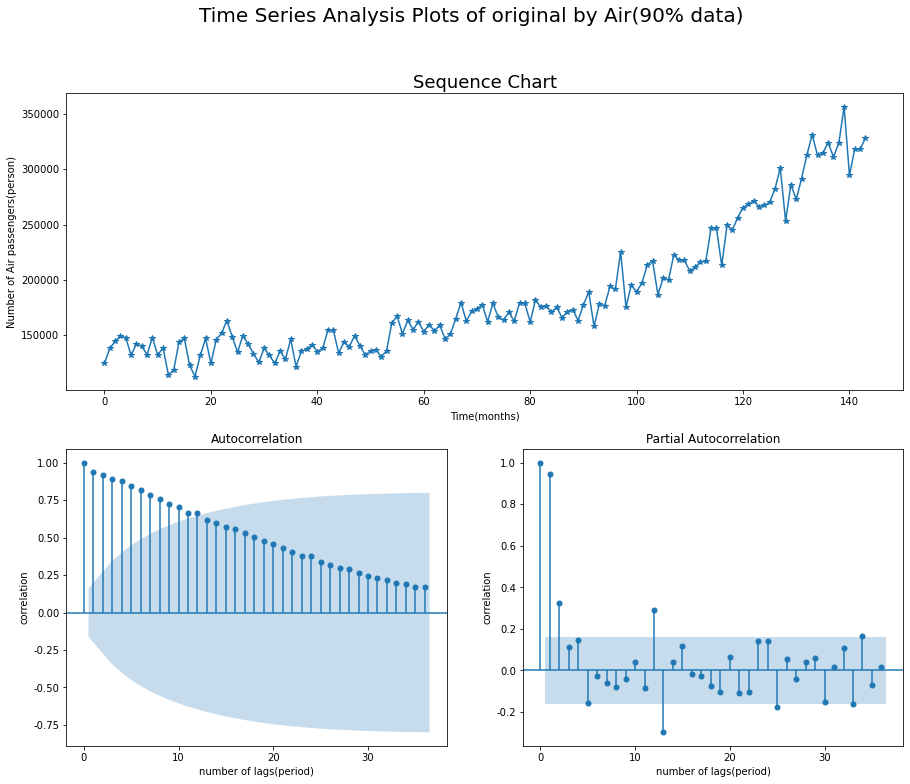

In [6]:
## read data
dfname='按入境渠道统计之来澳旅客空路人次'
Type = 'Air'
y=pd.read_excel('%s.xlsx'%dfname,header=None)
y.iloc[:,1]=y.iloc[:,1]
y=y.values[:,1].astype('float')

## Take 90% of the data
# mylen=int(len(y)*0.9)
mylen = 144             # 2008.1--2019.12疫情前的数据
party=y[0:mylen]

## plot figure
notes = 'original'      # 原始序列
drawts(party,dfname,Type,notes)

## 2-差分运算：使序列平稳化
### 2.1-判断是否是异方差

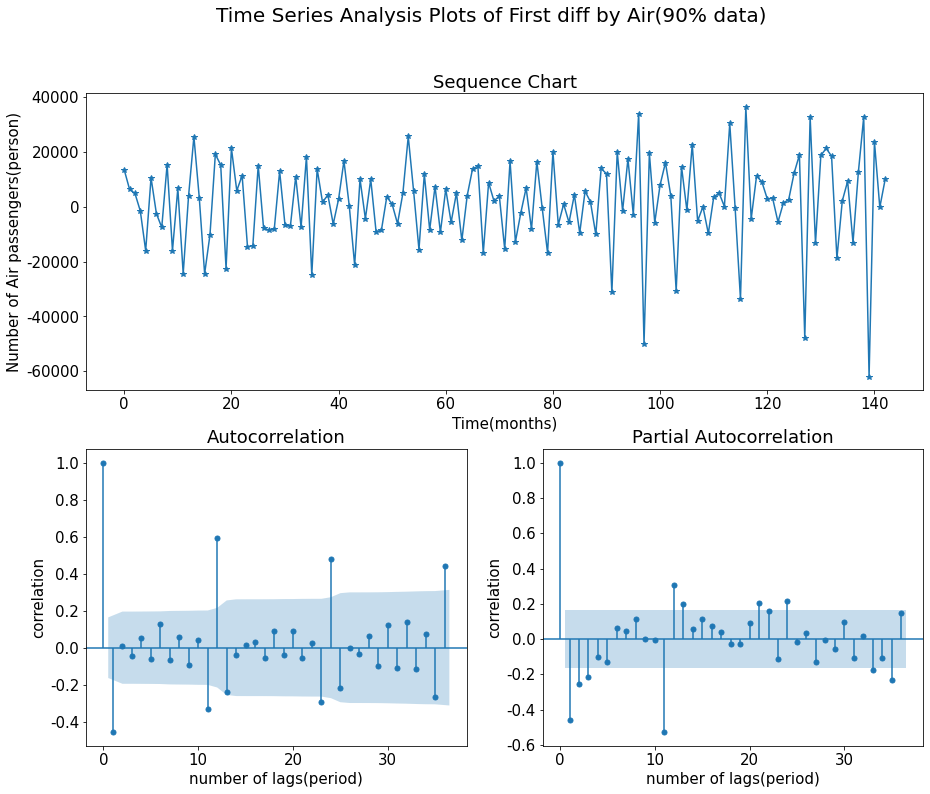

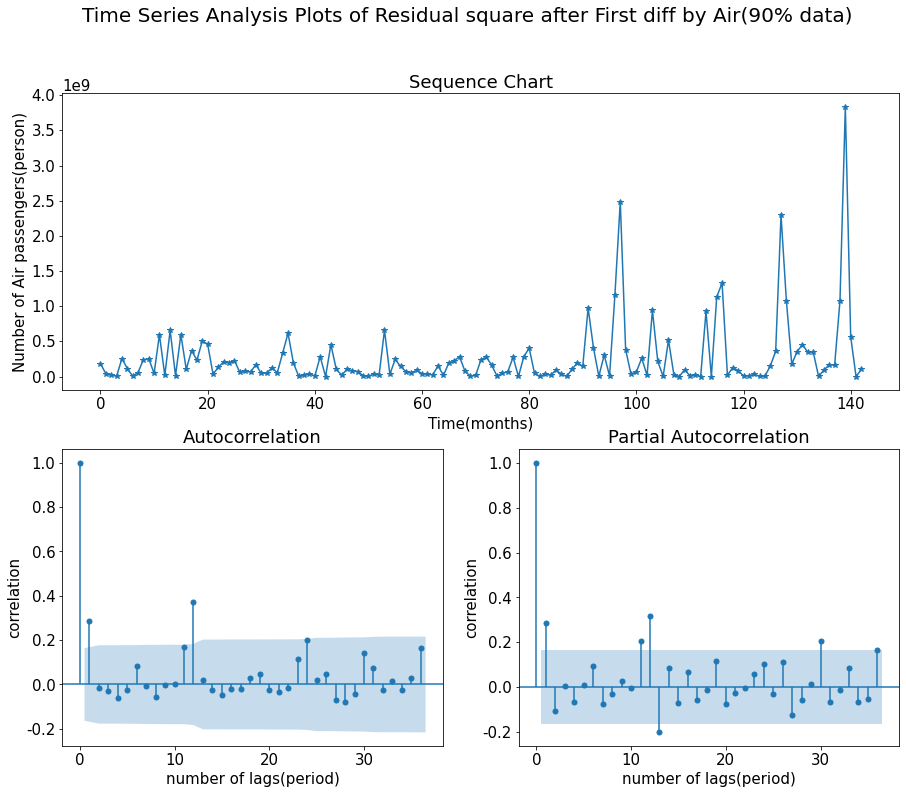

In [7]:
## 一阶差分
yd=party[1:]-party[:-1]
notes = 'First diff'    # 一阶差分
drawts(yd,dfname,Type,notes)

## 一阶差分后的残差平方图
notes = 'Residual square after First diff'    # 一阶差分后的残差平方图
drawts(yd**2,dfname,Type,notes)

### 2.2-方差齐性变换
$$  y_t=log(x_t)  $$

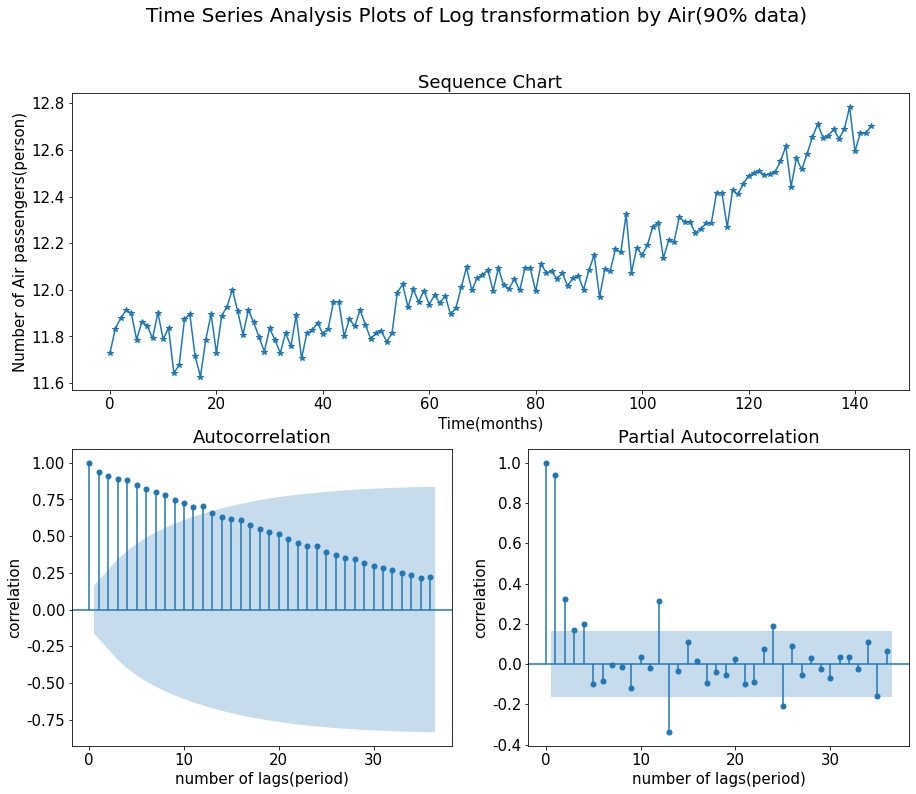

In [8]:
## 对数变换
newy=np.log(party)
notes = 'Log transformation'   # 对数变换后
drawts(newy,dfname,Type,notes)

### 2.3-对数变换后一阶12步差分

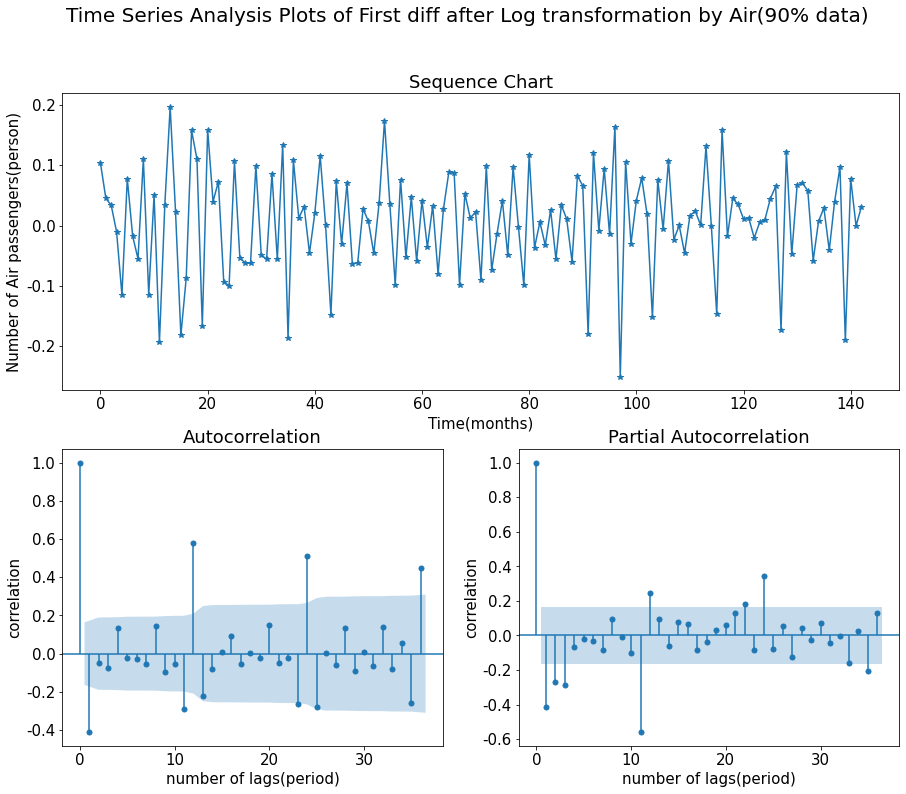

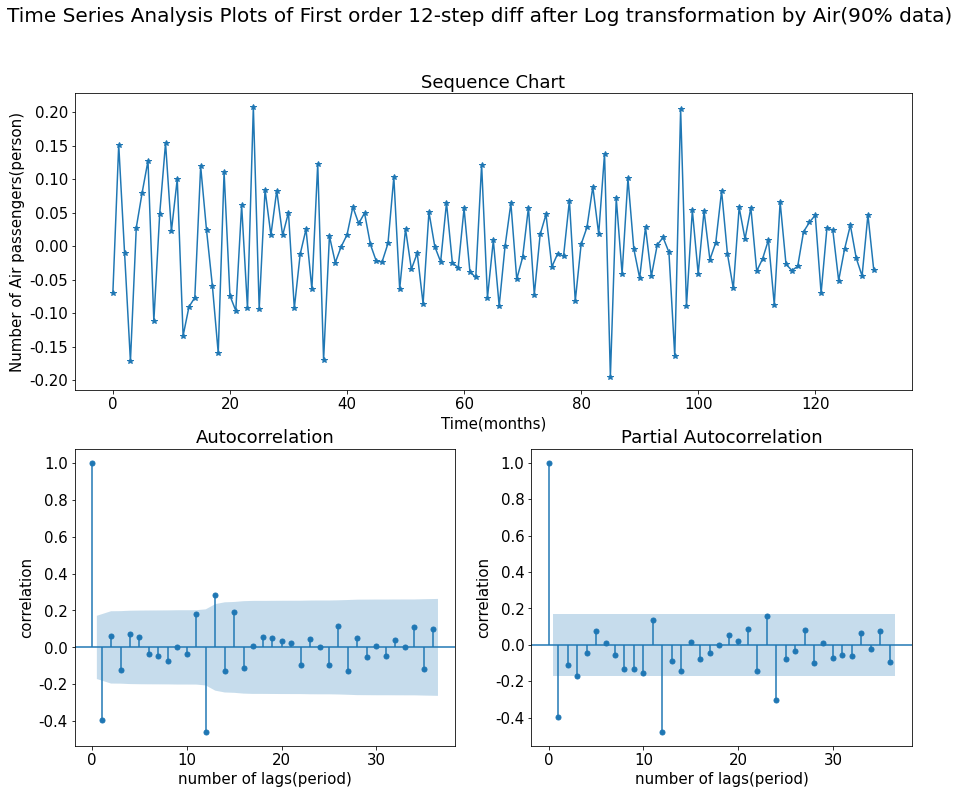

In [9]:
## 一阶差分
yd=newy[1:]-newy[:-1]
notes = 'First diff after Log transformation'   # 对数变换后一阶差分
drawts(yd,dfname,Type,notes)

## 12步差分
yd=yd[12:]-yd[:-12]
notes = 'First order 12-step diff after Log transformation'   # 对数变换后一阶12步差分
drawts(yd,dfname,Type,notes)

## 3-白噪声检验

In [10]:
purerandtest(yd)

----time series: LB pure randomness test----
           LB        Pvalue  lags
0   20.635966  5.554283e-06     1
1   21.145840  2.559996e-05     2
2   23.231127  3.614217e-05     3
3   23.987722  8.032865e-05     4
4   24.406322  1.813541e-04     5
5   24.609930  4.031490e-04     6
6   24.881039  7.965367e-04     7
7   25.662927  1.199223e-03     8
8   25.663094  2.318901e-03     9
9   25.849914  3.947374e-03    10
10  30.654471  1.249583e-03    11
11  61.634375  1.134876e-08    12
12  73.448895  1.849231e-10    13
13  75.815890  1.676048e-10    14
14  81.329631  3.987157e-11    15
15  83.301662  4.204861e-11    16
16  83.310126  9.848216e-11    17
17  83.791617  1.844729e-10    18
18  84.186968  3.492711e-10    19
19  84.392430  6.966377e-10    20
20  84.474813  1.423644e-09    21
21  85.891856  1.697041e-09    22
22  86.228788  3.026321e-09    23
23  86.232211  6.003967e-09    24


- 差分后LB统计量对应的6、12期的P值<0.05，是非白噪声序列

## 4-建模，参数估计

### 4.1-模型定阶

In [11]:
from itertools import product
# ARIMA的参数
ps = range(1, 3)
d = range(1, 2)
qs = range(1, 3)
# 季节项相关的参数
Ps = range(0, 1)
D = range(1, 2)
Qs = range(1, 2)
m = 12
# 将参数打包，传入下面的数据，是哦那个BIC准则进行参数选择
params_list = list(product(ps, d, qs, Ps, D, Qs))

result_table = find_best_params(newy, params_list,m)
print(result_table)

SARIMA(1, 1, 1)x(0, 1, 1, 12)
SARIMA(1, 1, 2)x(0, 1, 1, 12)
SARIMA(2, 1, 1)x(0, 1, 1, 12)
SARIMA(2, 1, 2)x(0, 1, 1, 12)

                      parameters         AIC         BIC
0  SARIMA(1, 1, 1)x(0, 1, 1, 12) -369.075601 -357.574812
1  SARIMA(2, 1, 1)x(0, 1, 1, 12) -368.366765 -353.990779
2  SARIMA(1, 1, 2)x(0, 1, 1, 12) -368.357904 -353.981917
3  SARIMA(2, 1, 2)x(0, 1, 1, 12) -366.365642 -349.114458


### 4.2-使用$SARIMA(p,d,q)(P,D,Q)_m$建模
$$
(1-\phi_1B-...-\phi_pB^p)(1-\Phi_1B-...-\Phi_pB^{Pm})(1-B^m)^D(1-B)^dx_t=(1-\theta_1B-...-\theta_qB^q)(1-\Theta_1B-...-\Theta_QB^{Qm})\varepsilon_t
$$

In [12]:
## SARIMA 
arma10=smt2.ARIMA(newy,order=(1,1,1),seasonal_order=(0,1,1,12),trend='n').fit() #trend=n,c,t,ct
print('----fitting summary----')
print(arma10.summary())

----fitting summary----
                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  144
Model:             ARIMA(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 188.538
Date:                          Fri, 03 Dec 2021   AIC                           -369.076
Time:                                  12:25:26   BIC                           -357.575
Sample:                                       0   HQIC                          -364.402
                                          - 144                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3961      0.157      2.523      0.012       0.088       0.704
ma.L1         -0.7697      

## 5-模型显著性检验（残差检验）

In [13]:
resid=arma10.resid
print('\n----residual pure randomness test')
purerandtest(resid)


----residual pure randomness test
----time series: LB pure randomness test----
           LB    Pvalue  lags
0    0.011129  0.915984     1
1    0.013315  0.993364     2
2    0.013477  0.999586     3
3    0.021922  0.999940     4
4    0.025515  0.999995     5
5    0.025958  1.000000     6
6    0.026122  1.000000     7
7    0.026135  1.000000     8
8    0.030511  1.000000     9
9    0.062582  1.000000    10
10   0.063346  1.000000    11
11  27.080676  0.007523    12
12  27.081000  0.012127    13
13  27.094133  0.018718    14
14  27.097814  0.027949    15
15  27.117415  0.040196    16
16  27.118233  0.056356    17
17  27.121245  0.076749    18
18  27.148294  0.101246    19
19  27.151903  0.131044    20
20  27.156405  0.165736    21
21  27.184603  0.204299    22
22  27.188154  0.248044    23
23  27.212064  0.294666    24


- 残差序列在6、12期的LB统计量对应的P值>0.05，显著，残差序列为白噪声序列，即拟合模型显著有效

## 6-拟合+7-预测

In [14]:
myalpha=0.05
mypred=arma10.get_prediction(start=1,end=len(y),dynamic=False)  ##if True, start >0

## 
mypred.predicted_mean[:]=np.exp(mypred.predicted_mean[:])
mypred.conf_int(0.05)[:,:]=np.exp(mypred.conf_int(0.05)[:,:])

## fitted
print('\n----fitted confidence interval: %d %%'%((1-myalpha)*100))
print(mypred.summary_frame(alpha=myalpha))


----fitted confidence interval: 95 %
y             mean      mean_se  mean_ci_lower  mean_ci_upper
0    124224.999038  1000.000002  122265.035049  126184.963028
1    137721.999559  1000.000002  135762.035570  139681.963548
2    144059.999809  1000.000002  142100.035820  146019.963798
3    148971.999916  1000.000002  147012.035926  150931.963905
4    147447.999971  1000.000002  145488.035981  149407.963960
..             ...          ...            ...            ...
160  393797.244798     0.127957  393796.994006  393797.495590
161  420297.971936     0.131430  420297.714339  420298.229534
162  446753.737288     0.134805  446753.473074  446754.001502
163  377153.072144     0.138096  377152.801481  377153.342808
164  418027.662947     0.141309  418027.385987  418027.939907

[165 rows x 4 columns]


## 8-绘图

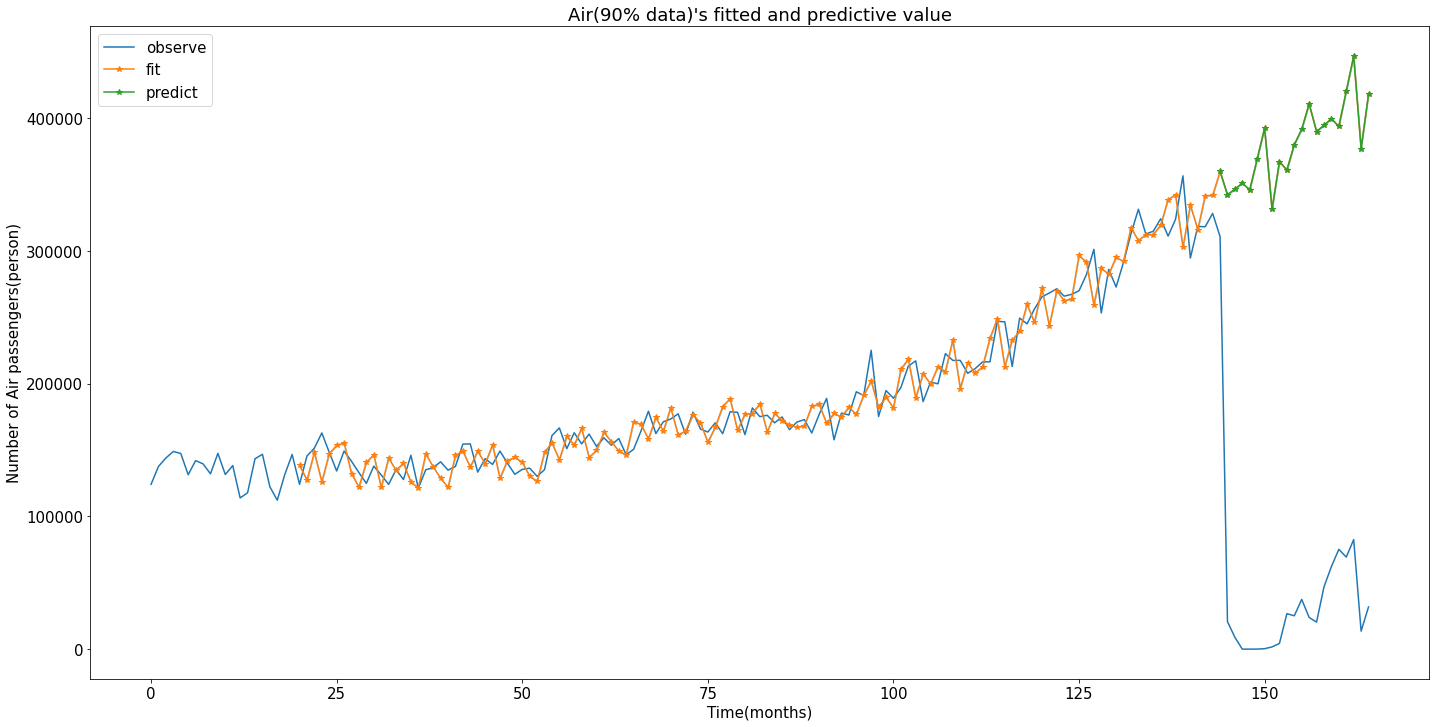

In [18]:
plot_all(y,mypred,Type,mylen)

## 9-评价疫情恢复情况

> 146期（对应index=145）为疫情发生月、判断147~165期的疫情恢复情况

- 第0期的真实值（疫情发生月）：$A_0$
- 第0期的估计值（疫情发生月）：$P_0$
- 第i期的真实值（有疫情）：$A_i$
- 第i期的估计值（无疫情）：$P_i$
- 第i期的旅客人数恢复率：${RE}_i$
$${RE}_i = 1 - \cfrac{\cfrac{(P_i-A_i)}{P_i}}{\cfrac{(P_0-A_0)}{P_0}},i=147,148,...165$$

In [16]:
REi = []
for i in range(mylen+2,len(y)):
    REi.append(1 - ((mypred.predicted_mean[i]-y[i])/mypred.predicted_mean[i])/((mypred.predicted_mean[145]-y[145])/mypred.predicted_mean[145])) 

print(REi)
pd.DataFrame(REi[:]).to_excel('../REi_plot/AirREi.xlsx')   # 存储拟合值

[-0.03716571198361018, -0.06447413950442638, -0.06444065277347932, -0.06433334883370634, -0.06356879925627235, -0.059072107149794384, -0.05196603671164102, 0.01431648784063444, 0.005940322943366327, 0.037357966674546605, -0.0026308181402980857, -0.008871107171705583, 0.062104579519369985, 0.10128850199102324, 0.13876842515762988, 0.11111306267636833, 0.13214447035843613, -0.026205815468856697, 0.016471184027602392]
